In [35]:
from utils import extract_data

extract_data('data')

In [36]:
from sklearn.preprocessing import StandardScaler

from utils import preprocess

# Set up scaler.
scaler = StandardScaler()

color_data = preprocess("data/imgs/color", scaler)
grayscale_data = preprocess("data/imgs/grayscale", scaler)
segmented_data = preprocess("data/imgs/segmented", scaler)

In [37]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(color_data[0], color_data[1], test_size=0.2)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(2305, 12288) (577, 12288) (2305,) (577,)


In [38]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

randomForestModel = RandomForestClassifier()
svmModel = SVC()
knnModel = KNeighborsClassifier()
decTreeModel = DecisionTreeClassifier()

In [39]:
randomForestModel.fit(X_train, y_train)
svmModel.fit(X_train, y_train)
knnModel.fit(X_train, y_train)
decTreeModel.fit(X_train, y_train)

DecisionTreeClassifier()

----- Random Forest Classifier -----
 > Train accuracy: 100.00%
 > Test score: 93.07%


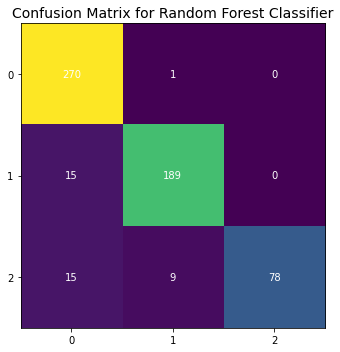

 > Classification Report:
              precision    recall  f1-score   support

         0.0       0.90      1.00      0.95       271
         1.0       0.95      0.93      0.94       204
         2.0       1.00      0.76      0.87       102

    accuracy                           0.93       577
   macro avg       0.95      0.90      0.92       577
weighted avg       0.94      0.93      0.93       577

----- Support Vector Machine -----
 > Train accuracy: 99.91%
 > Test score: 98.79%


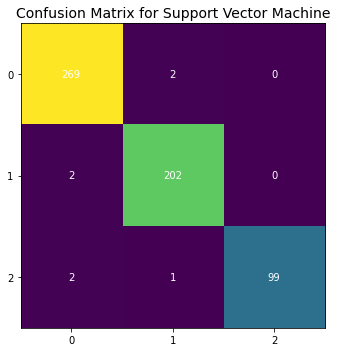

 > Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99       271
         1.0       0.99      0.99      0.99       204
         2.0       1.00      0.97      0.99       102

    accuracy                           0.99       577
   macro avg       0.99      0.98      0.99       577
weighted avg       0.99      0.99      0.99       577

----- K-Nearest Neighbors -----
 > Train accuracy: 89.85%
 > Test score: 88.56%


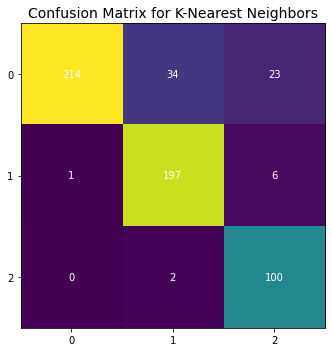

 > Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.79      0.88       271
         1.0       0.85      0.97      0.90       204
         2.0       0.78      0.98      0.87       102

    accuracy                           0.89       577
   macro avg       0.87      0.91      0.88       577
weighted avg       0.90      0.89      0.89       577

----- Decision Tree -----
 > Train accuracy: 100.00%
 > Test score: 77.47%


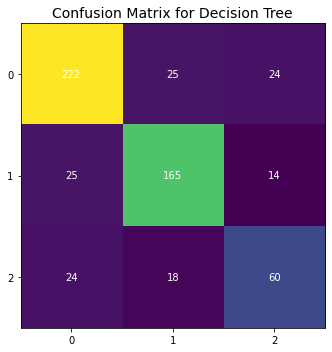

 > Classification Report:
              precision    recall  f1-score   support

         0.0       0.82      0.82      0.82       271
         1.0       0.79      0.81      0.80       204
         2.0       0.61      0.59      0.60       102

    accuracy                           0.77       577
   macro avg       0.74      0.74      0.74       577
weighted avg       0.77      0.77      0.77       577



In [40]:
from utils import evaluate

# Avaliando os modelos

RFres = evaluate(randomForestModel, X_train, y_train, X_test, y_test, 'Random Forest Classifier')
SVMres = evaluate(svmModel, X_train, y_train, X_test, y_test, 'Support Vector Machine')
KNNres = evaluate(knnModel, X_train, y_train, X_test, y_test, 'K-Nearest Neighbors')
DTres = evaluate(decTreeModel, X_train, y_train, X_test, y_test, 'Decision Tree')

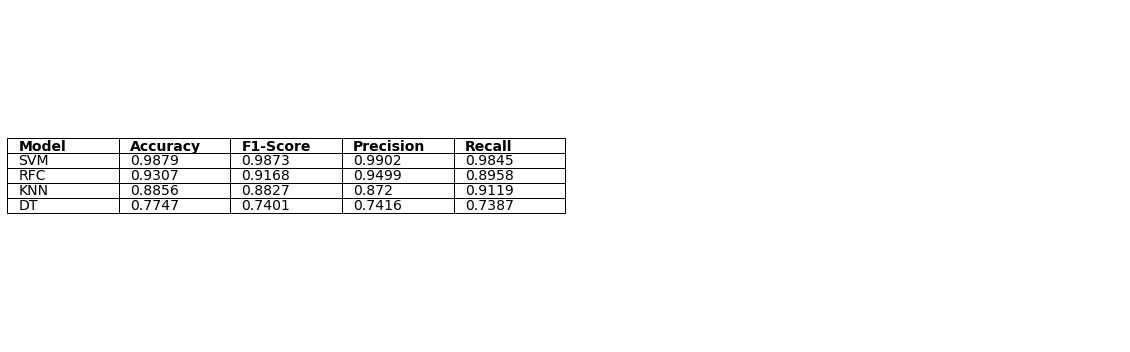

In [41]:
from utils import table_results


table_results({
    'RFC': RFres,
    'SVM': SVMres,
    'KNN': KNNres,
    'DT': DTres
})
